<a href="https://colab.research.google.com/github/kosebaris1/CNN_siniflandirma/blob/main/Model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---

* **Adınız:** Barış
* **Soyadınız:** Köse
* **Okul Numaranız:** 2212721022
* **GitHub Repo Bağlantısı:** https://github.com/kosebaris1/CNN_siniflandirma
---


# Model 1: Transfer Learning (VGG16 Mimarisi)

## Giriş ve Amaç
Bu not defterinde, sınıflandırma problemleri için literatürde başarısı kanıtlanmış (State-of-the-Art) mimarilerden biri olan **VGG16** modeli kullanılmıştır. Veri setimiz toplam 541 görüntüden oluşmaktadır.

## Veri Seti Hazırlığı ve Ayrıştırma
Modelin genelleme yeteneğini doğru ölçebilmek ve eğitim sırasında **aşırı öğrenmeyi (overfitting)** gözlemleyebilmek için veri seti üç parçaya ayrılmıştır:
1.  **Eğitim (Training - %70):** Modelin ağırlıklarını güncelleyerek öğrendiği veri.
2.  **Doğrulama (Validation - %15):** Eğitim sırasında modelin performansını izlediğimiz veri.
3.  **Test (Test - %15):** Modelin eğitim bittikten sonra, daha önce **hiç görmediği** veriler üzerindeki nihai başarısını ölçmek için ayrılan veri.

Bu ayrım, `split-folders` kütüphanesi ve `seed=1337` parametresi ile her çalıştırmada tutarlı olacak şekilde yapılmıştır.

In [1]:
# KURULUM, DRIVE VE VERİ AYRIŞTIRMA
!pip install split-folders
import tensorflow as tf
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
from google.colab import drive

# 1. Drive Bağlantısı
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Veri Yollarını Ayarlama

input_folder = '/content/drive/MyDrive/Colab Notebooks/datasets'

# Colab'in içinde oluşturacağımız ayrıştırılmış klasör (Hızlı çalıştırma olduğu için bu şekilde tercih ettim)
output_folder = '/content/split_dataset'

# 3. Veriyi Ayırma İşlemi (Train: %70, Val: %15, Test: %15)
print("Veriler Train, Val ve Test olarak ayrıştırılıyor... Lütfen bekleyin.")
# seed=1337: Her seferinde aynı resimlerin aynı yere gitmesi için bunu ayarladım (kararlılık)
splitfolders.ratio(input_folder, output=output_folder,
                   seed=1337, ratio=(.7, .15, .15), group_prefix=None, move=False)
print("Ayrıştırma Tamamlandı! Klasör: /content/split_dataset")

Mounted at /content/drive
Veriler Train, Val ve Test olarak ayrıştırılıyor... Lütfen bekleyin.


Copying files: 541 files [00:30, 17.78 files/s]

Ayrıştırma Tamamlandı! Klasör: /content/split_dataset


## Veri Ön İşleme (Preprocessing)

Derin öğrenme modelleri ham piksel değerleri (0-255 arası) yerine, normalize edilmiş küçük değerlerle (0-1 arası) daha hızlı ve kararlı çalışır. Bu nedenle:

* **Normalizasyon (Rescaling):** Tüm piksel değerleri `1./255` işlemi ile 0 ile 1 arasına sıkıştırılmıştır.
* **Augmentation (Veri Artırımı):** Bu aşamada (Model 1), VGG16'nın ham performansını ve Transfer Learning yeteneğini net görmek amacıyla herhangi bir veri artırımı (döndürme, kaydırma vb.) **uygulanmamıştır**.
* **Hedef Boyut:** VGG16 mimarisine uygun ve işlem yükünü dengede tutmak adına görüntüler **128x128** piksel boyutuna yeniden boyutlandırılmıştır.

In [2]:
# GENERATOR (ÜRETEÇLER)
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# Sadece normalizasyon yapıyoruz (Model 1 için Augmentation yok)
datagen = ImageDataGenerator(rescale=1./255)

print("\n--- Veri Seti Dağılımı ---")
# Eğitim Seti
train_generator = datagen.flow_from_directory(
    f'{output_folder}/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Doğrulama Seti
validation_generator = datagen.flow_from_directory(
    f'{output_folder}/val',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Test Seti (Shuffle=False yapıyoruz ki sırası karışmasın, analiz kolay olsun)
test_generator = datagen.flow_from_directory(
    f'{output_folder}/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


--- Veri Seti Dağılımı ---
Found 378 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 83 images belonging to 2 classes.


## Model Mimarisi ve Transfer Learning Stratejisi

Bu projede **VGG16** modeli, **ImageNet** veri seti üzerinde eğitilmiş ağırlıklarıyla birlikte yüklenmiştir.

### Kullanılan Strateji: Feature Extraction (Öznitelik Çıkarımı)
ImageNet gibi devasa (1.2 milyon görüntü) bir veri setinde eğitilen VGG16; kenar, köşe, doku ve şekil gibi temel görsel özellikleri tanımayı zaten bilmektedir.

### Neden Özellikle VGG16 Mimarisi Tercih Edildi?

Bu projede daha karmaşık veya daha yeni modeller yerine VGG16'nın seçilmesinin **üç temel teknik nedeni** vardır:

1.  **Doku ve Desen Odaklı Başarım:**
    Banknot sınıflandırma problemi, nesnenin genel şeklinden ziyade üzerindeki **ince dokular, geometrik desenler ve sayısal karakterlerin** ayırt edilmesine dayanmaktadır. VGG16 mimarisi, kullandığı küçük boyutlu (3x3) ardışık filtreler sayesinde bu tür "düşük seviyeli (low-level)" doku özniteliklerini yakalamada başarılı olmasından tercih edilmiştir.

2.  **Küçük Veri Seti Uyumluluğu:**
    Elimizdeki veri seti (sınıf başına ~200 görüntü) derin öğrenme için "küçük" kabul ediliyor. ResNet veya Inception gibi çok daha derin ve karmaşık ağlar, bu kadar az veriyle eğitildiğinde ağırlıklarını optimize etmekte zorlanabilir ve daha hızlı "Overfitting" (Ezberleme) tuzağına düşebilir. VGG16, daha sade ve doğrusal yapısıyla transfer learning için daha stabil bir taban oluşturduğundan dolayı tercih edilmiştir.

3.  **Sade ve Anlaşılır Mimari:**
    VGG16, ardışık konvolüsyon ve havuzlama (pooling) katmanlarından oluşan doğrusal bir mimariye sahiptir. Bu yapı, modelin hangi katmanda ne tür özellikleri (kenar, şekil, obje) öğrendiğini analiz etmeyi ve proje kapsamında ince ayar (fine-tuning) yapmayı kolaylaştırmaktadır.

### Mimari Detayları:
1.  **VGG16 Tabanı (Base):** Modelin evrişimsel (convolutional) katmanları alınmış ancak sınıflandırma (Fully Connected) katmanları (`include_top=False`) dahil edilmemiştir.
2.  **Dondurma (Freezing):** `vgg_base.trainable = False` komutu ile VGG16'nın ağırlıkları dondurulmuştur. Böylece eğitim sırasında bu değerli bilgiler bozulmayacak, sadece bizim eklediğimiz yeni katmanlar eğitilecektir.
3.  **Özel Sınıflandırma Katmanları:**
    * **Flatten:** 3 boyutlu özellik haritalarını tek boyutlu vektöre çevirir.
    * **Dense (256 Nöron):** Modelin kendi veri setimizdeki özellikleri öğrenmesi için eklenen ara katman. `ReLU` aktivasyonu kullanılmıştır.
    * **Dropout (0.5):** Modelin eğitim verisini ezberlemesini (Overfitting) engellemek için nöronların %50'si rastgele kapatılır.
    * **Çıktı Katmanı (Softmax):** 2 sınıfımız (TL ve USD) olduğu için, her sınıfa ait olasılık değerini üretir.

In [3]:
# (VGG16) KURULUMU

vgg_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
vgg_base.trainable = False # Tabanı dondur

model1 = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax') # 2 Sınıf: TL ve USD
])

model1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model1.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,610 (64.14 MB)

 Trainable params: 2,097,922 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Modelin Eğitilmesi

Model, aşağıdaki hiperparametreler ile derlenmiş ve eğitime alınmıştır:

* **Optimizer:** `Adam` (Learning Rate: 0.001). Adaptif öğrenme hızı sağladığı için tercih edilmiştir.
* **Loss Function:** `Categorical Crossentropy`. Çok sınıflı (bu örnekte 2 sınıf ve one-hot encoding yapısı) sınıflandırma problemleri için standart kayıp fonksiyonudur.
* **Epoch:** Transfer Learning kullanıldığı ve model hızlı yakınsadığı için **10 Epoch** yeterli görülmüştür.

In [4]:
# EĞİTİM
print("\n--- Model 1 Eğitiliyor ---")
history1 = model1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)


--- Model 1 Eğitiliyor ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 61s 5s/step - accuracy: 0.4246 - loss: 1.7613 - val_accuracy: 0.6406 - val_loss: 0.5649
Epoch 2/10
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5625 - loss: 0.7308

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 798ms/step - accuracy: 0.5625 - loss: 0.7308 - val_accuracy: 0.8281 - val_loss: 0.5016
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.7828 - loss: 0.4966 - val_accuracy: 0.8594 - val_loss: 0.4077
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 796ms/step - accuracy: 0.8750 - loss: 0.3207 - val_accuracy: 0.8594 - val_loss: 0.3773
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.9154 - loss: 0.3051 - val_accuracy: 0.8594 - val_loss: 0.3514
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 873ms/step - accuracy: 0.9375 - loss: 0.2202 - val_accuracy: 0.9062 - val_loss: 0.2977
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.9291 - loss: 0.2322 - val_accuracy: 0.8594 - val_loss: 0.3236
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 869ms/step - accuracy: 0.9062 - loss: 0.3093 - val_accuracy: 0.9219 - val_loss: 0.2361
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.9535 - loss: 0.1899 - val_accuracy: 0.8750 - val_loss: 0.

## Performans Görselleştirmesi

Eğitim sürecinin başarısını analiz etmek için **Accuracy (Doğruluk)** ve **Loss (Kayıp)** grafikleri çizdirilmiştir.
* **İdeal Senaryo:** "Training" ve "Validation" çizgilerinin birbirine yakın ve paralel hareket etmesi, Loss değerinin ise istikrarlı bir şekilde düşmesidir. Aşağıda görüldüğü üzere Validation ve Trainig çizgileri paralel ilerlemektedir.
* **Overfitting Kontrolü:** Eğer Training başarısı çok yüksekken Validation başarısı düşük kalırsa, model ezberliyor demektir. Dropout katmanı ve dondurma işlemi bunu engellemek için kullanılmıştır. Accuracy:0.8750 , val_accuracy:0.8594 değerlerinde göründüğü üzere aşırı öğrenme engellenmiştir.

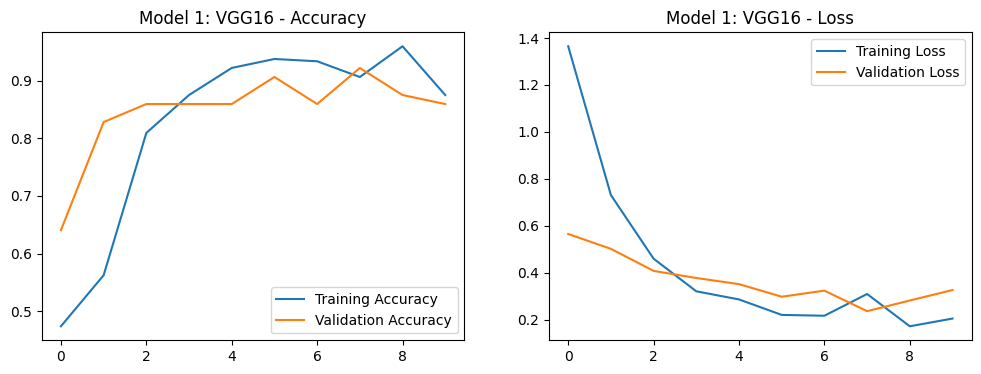

In [5]:
# SONUÇLAR VE GRAFİK
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    plt.show()

plot_history(history1, "Model 1: VGG16")

## Final Test Aşaması

Modelin gerçek başarısı, eğitim ve doğrulama süreçlerinde **hiç kullanılmamış** olan **Test Seti** üzerinde ölçülmüştür. Bu sonuç, modelin gerçek dünyada (canlı sistemde) göstereceği performansa en yakın değerdir. Aşağıda görüldüğü üzere Final test doğruluğu %92.77 çıkmıştır.

In [6]:
# TEST SETİ DEĞERLENDİRMESİ
print("TEST AŞAMASI (Hiç Görülmemiş Veri)")
test_loss, test_acc = model1.evaluate(test_generator)
print(f"\n Model 1 FİNAL Test Doğruluğu: %{test_acc*100:.2f}")

TEST AŞAMASI (Hiç Görülmemiş Veri)
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.9326 - loss: 0.2197

 Model 1 FİNAL Test Doğruluğu: %92.77
